In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import math
import matplotlib
#matplotlib.use("Agg")
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
from data_utils import load_data, augment_data,normalise_train,normalise_test,rgb2gray,rgb2lab,lab2rgb
import matplotlib.pyplot as plt
from tucha import complex_pokemon_model,baselinish,simpler_model,baselinish2,complex_pokemon_model2,baselinish3

from cs231n.data_utils import load_CIFAR10

In [2]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1,3])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,3]))
    return

In [3]:
def show_images2(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]),cmap = plt.get_cmap('gray'))
    return

Training data shape:  (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)


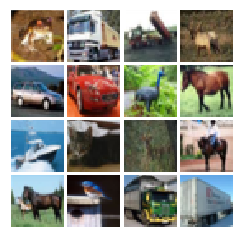

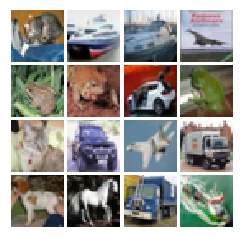

In [4]:
# Load the raw CIFAR-10 data.
from skimage import img_as_float
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Test data shape: ', X_test.shape)
X_train = img_as_float(X_train.astype('uint8'))
X_test = img_as_float(X_test.astype('uint8'))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
show_images(X_train[:16])
show_images(X_test[:16])

In [5]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(alpha*x,x)

In [6]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate,beta1 = beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate,beta1 = beta1)
    return D_solver, G_solver

In [7]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    label_one = tf.ones_like(logits_fake)
    label_zero = tf.zeros_like(logits_fake)
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_fake,labels = label_one))
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_real,labels = label_one) + \
             tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_fake,labels = label_zero) )  
    return D_loss, G_loss

In [8]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    G_loss = 0.5*tf.reduce_mean(tf.square(score_fake-1))
    D_loss = 0.5*tf.reduce_mean(tf.square(score_real-1) + tf.square(score_fake))
    return D_loss, G_loss

In [19]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        #reshaped_x = tf.transpose(x,perm = [0,2,3,1])
        reshaped_x = x
        a1 = tf.layers.conv2d(reshaped_x,filters = 32,kernel_size = [5,5],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [5,5],activation = leaky_relu,padding = 'same')
        
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        a1 = tf.layers.conv2d(a1,filters = 128,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        a1 = tf.layers.conv2d(a1,filters = 256,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        a1 = tf.layers.conv2d(a1,filters = 512,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        a1 = tf.reshape(a1,shape=[-1,512])
        a1 = tf.layers.dense(a1,512,activation = leaky_relu)
        logits = tf.layers.dense(a1,1)
        
        
        
        return logits

In [29]:
def generator(X):
    
    with tf.variable_scope("generator"):
        Float_image = X
        conv_mat = tf.constant(np.array([[0.299,0.587,0.114],[-0.14713,-0.2888,0.436],[0.615,-0.514999,-0.10001]]),dtype = tf.float32)
        inv_conv_mat = tf.constant(np.array([[1,0,1.13983],[1,-0.39465,-0.58060],[1,2.03211,0]]),dtype = tf.float32)

        Float_image = tf.reshape(Float_image,[-1,3])

        YUV_image = tf.matmul(Float_image,conv_mat)
        YUV_image = tf.reshape(YUV_image,[-1,32,32,3])
        Float_image = tf.reshape(Float_image,[-1,32,32,3])
        UV_p = YUV_image[:,:,:,1:3]
        Y_p = YUV_image[:,:,:,0:1]
        noise = tf.random_normal(shape = tf.shape(Y_p),mean = 0.0,stddev = 0.01)
        Y_pn = Y_p + noise

        a1 = tf.layers.conv2d(Y_pn,filters = 8,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(Y_p,filters = 16,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 32,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)


        a1 = tf.layers.conv2d(a1,filters = 32,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        
        #a1 = tf.layers.conv2d_transpose(a1,filters = 64, kernel_size = [4,4],strides = [2,2],activation = leaky_relu,padding = 'same')
        #a1 = tf.layers.batch_normalization(a1,training = True)
        
        
        a1 = tf.layers.conv2d(a1,filters = 32,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        
        a1 = tf.layers.conv2d(a1,filters = 32,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        
        a1 = tf.layers.conv2d(a1,filters = 16,kernel_size = [1,1],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 16,kernel_size = [1,1],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        

        
        a1 = tf.layers.conv2d(a1,filters = 8,kernel_size = [1,1],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 4,kernel_size = [1,1],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 2,kernel_size = [1,1],activation = tf.tanh,padding = 'same')



        a3 = tf.concat((Y_p,a1),axis = 3)
        #a2 = tf.image.hsv_to_rgb(a3)
        a3 = tf.reshape(a3,[-1,3])
        a2 = tf.matmul(a3,inv_conv_mat)
        RGB_out = tf.reshape(a2,[-1,32,32,3])

    
    return RGB_out,Y_pn

In [30]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 32,32,3])
y = tf.placeholder(tf.float32,[None,10])
#z = sample_noise(batch_size, noise_dim)
# generated images
G_sample,G_in = generator(x)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(x)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers(learning_rate = 1e-4,beta1 = 0.9)
D_loss, G_loss = gan_loss(logits_real, logits_fake)
#G_loss += tf.reduce_mean(tf.nn.l2_loss(x-G_sample))
#G_loss += tf.reduce_mean(tf.square(x-G_sample))
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

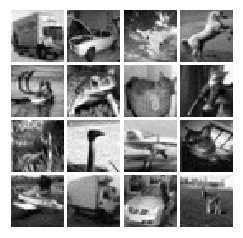

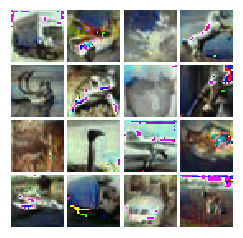

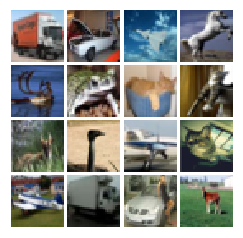

In [34]:
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess,'../models/gan_model_cifar')
rand_indices = np.random.choice(np.arange(10000),batch_size)
minibatch = X_test[rand_indices]
samples_gray = sess.run(G_in,feed_dict = {x:minibatch})
fig = show_images2(samples_gray[:16])
plt.show()
samples = sess.run(G_sample,feed_dict = {x:minibatch})
fig = show_images(samples[:16])
plt.show()
fig = show_images(minibatch[:16])
plt.show()
#sess.run(tf.global_variables_initializer())
#run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,num_epoch = 1)